# Equivalent layer technique for estimating total magnetization direction using airborne survey

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
import string as st
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_magdirection_RM.ipynb'

#### Importing auxiliary functions

In [4]:
dir_modules = '../../mypackage'
sys.path.append(dir_modules)

In [5]:
import auxiliary_functions as fc

#### Loading properties of the model

In [6]:
with open('data/model_prism.pickle') as f:
        model_prism = pickle.load(f)

#### Loading properties grid

In [7]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [8]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [9]:
result_RM_airb = dict()

### Saving files

In [10]:
saved_files = []

## Observation area

In [11]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 6000.0 m 
 x_min = -6000.0 m 
 y_max = 6000.0 m 
 y_min = -6000.0 m


### airborne survey information

In [12]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (40,20)
Number of data: 800.0
dx: 307.7 m
dy: 631.6 m 


## Properties of the model

### Main field

In [13]:
inc_gf,dec_gf = model_prism['main_field']

In [14]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 30.0 degree
Main field declination: 40.0 degree


### Magnetization direction

In [15]:
print 'Intensity: %.1f A/m' % model_prism['m_R']
print 'Inclination: %.1f degree' % model_prism['inc_R']
print 'Declination: %.1f degree' % model_prism['dec_R']

Intensity: 5.0 A/m
Inclination: 55.0 degree
Declination: 30.0 degree


In [16]:
inc_R,dec_R = model_prism['inc_R'],model_prism['dec_R']

## Generating the layer with my function 

In [17]:
h = 1200.

#### Generating a layer

In [18]:
shape_layer = (airborne['shape'][0],airborne['shape'][1])

In [19]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [20]:
i_pos = 1500

In [21]:
it_max = 30

In [22]:
it_marq = 15

In [23]:
lamb = 10.
dlamb = 100.

In [24]:
eps_e = 1e-5
eps_i = 1e-5

In [25]:
mu_pos = 0.

In [26]:
m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
    data['tfa_obs_prism_RM_airb'],airborne['x'],airborne['y'],
    airborne['z'],xs,ys,zs,inc_gf,dec_gf,-10.,-10.,lamb,dlamb,i_pos,it_max,
    it_marq,eps_e,eps_i,mu_pos)

i = 0
3.35857899893 -3.10513975794
0.411155829329
i = 1
9.55917088667 -1.70134166034
0.497002373332
i = 2
13.307336591 -1.09928798407
0.252635733934
i = 3
16.2028850118 -0.572901486094
0.188069517234
i = 4
18.4930898679 -0.130268969321
0.138243934727
i = 5
20.3813026374 0.239176448022
0.106481941275
i = 6
21.9848946486 0.578901707174
0.084788386257
i = 7
23.3685471453 0.876340348968
0.0697151614673
i = 8
24.5966259 1.15118543076
0.0584384479158
i = 9
25.6983947844 1.40813473595
0.0495350325672
i = 10
26.6979203758 1.65294867992
0.0425844320768
i = 11
27.6106852215 1.89605786336
0.0368721455077
i = 12
28.4506413046 2.13849248513
0.0322484616196
i = 13
29.2338516724 2.38600150403
0.028872853388
i = 14
29.9707175469 2.63995466512
0.0262534076303
i = 15
30.6658859738 2.89856381652
0.0239424818399
i = 16
31.3222530544 3.15488698894
0.0217810713797
i = 17
31.9436912024 3.40834563763
0.0198796605945
i = 18
32.5337526383 3.66210530352
0.0182392563297
i = 19
33.0961248129 3.92086780484
0.016871

50.8665171254 28.2441022754
7.47634603477e-05
i = 158
50.8970428648 28.2858839146
7.33170428284e-05
i = 159
50.9273344752 28.3270315149
7.1908761559e-05
i = 160
50.9573951692 28.3675557717
7.05373950597e-05
i = 161
50.9872280829 28.4074672245
6.92017637714e-05
i = 162
51.0168362775 28.4467762576
6.79007286438e-05
i = 163
51.0462227417 28.485493169
6.66332401453e-05
i = 164
51.0753903937 28.5236280788
6.53982150738e-05
i = 165
51.104342084 28.561190908
6.41945917671e-05
i = 166
51.1330805971 28.5981914265
6.30213803583e-05
i = 167
51.1616086532 28.6346392548
6.18776250252e-05
i = 168
51.1899289101 28.6705438648
6.0762402822e-05
i = 169
51.2180437823 28.7059140137
5.96738129291e-05
i = 170
51.245948645 28.7407366405
5.85729549543e-05
i = 171
51.2736390179 28.7751439998
5.75577769509e-05
i = 172
51.3011098069 28.8092716555
5.66250369849e-05
i = 173
51.328363455 28.8431216375
5.57097098633e-05
i = 174
51.3554023693 28.8766959634
5.48114225489e-05
i = 175
51.3822289219 28.9099966383
5.39298

### Visualization of the convergence

In [27]:
phi = (np.array(phi)/airborne['x'].size)

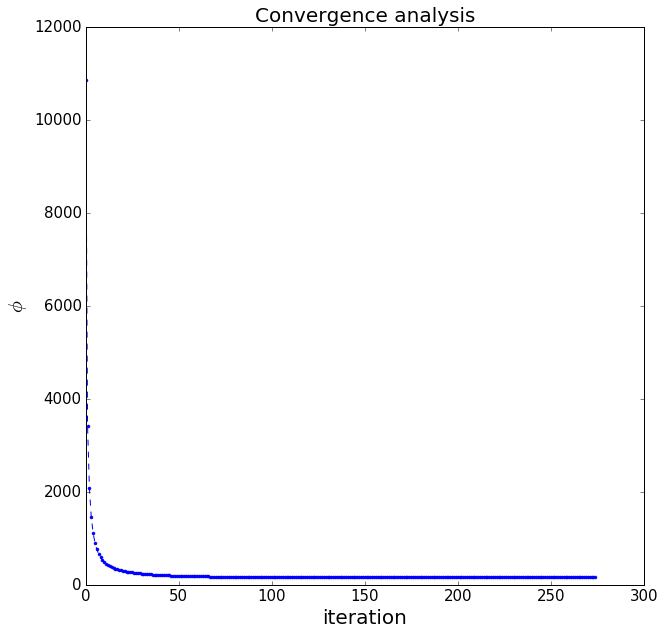

In [28]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b--')
plt.plot(phi, 'b.')

plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi$', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/airborne/convergence_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetization direction

In [29]:
print (inc_est,dec_est)

(53.178396253094313, 31.037480298726308)


In [30]:
print (inc_R,dec_R)

(55.0, 30.0)


### Comparison between observed data and predicted data

In [31]:
pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [32]:
res = pred - data['tfa_obs_prism_RM_airb']

In [33]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_prism_RM_airb'],pred)

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


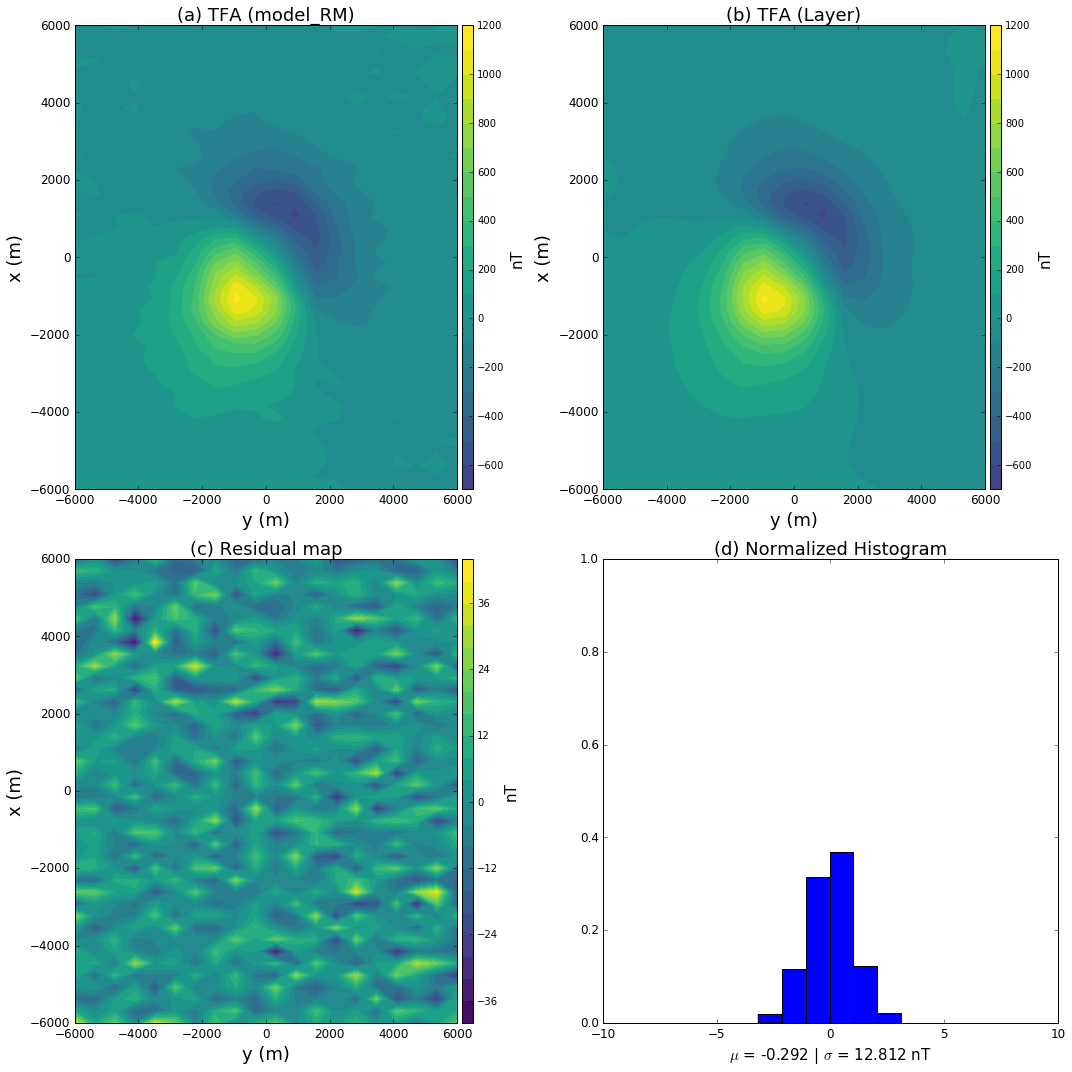

In [34]:
title_font = 18
bottom_font = 15
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(15,15), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_prism_RM_airb'].max(), 
                                   data['tfa_obs_prism_RM_airb'].min(),
                                   pred.max(), pred.min()]).max()
res_ranges = np.max(np.abs(res))

plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_prism_RM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_RM)',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             pred.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             res.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-res_ranges, vmax=res_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/data_fitting_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetic moment within the layer

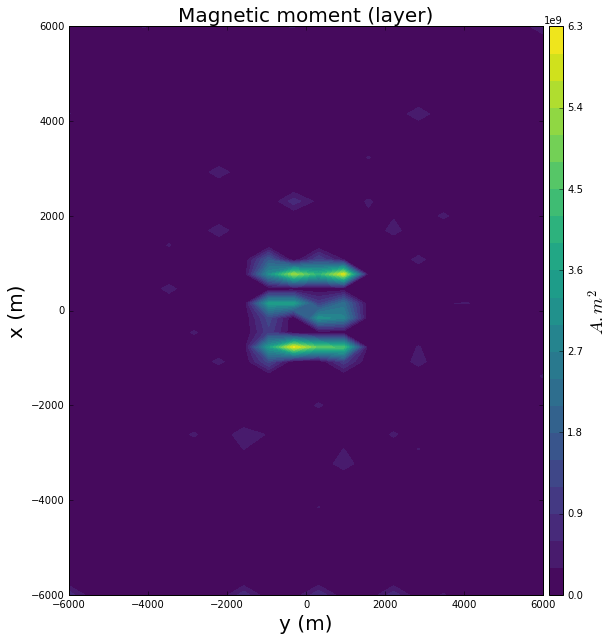

In [35]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer), 20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)

file_name = 'figs/airborne/magnetic_moment_positive_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Reduction to the pole

In [36]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [37]:
tfa_rtp = np.dot(G_rtp,m_LM)

#### Visualization of a reduction to the pole

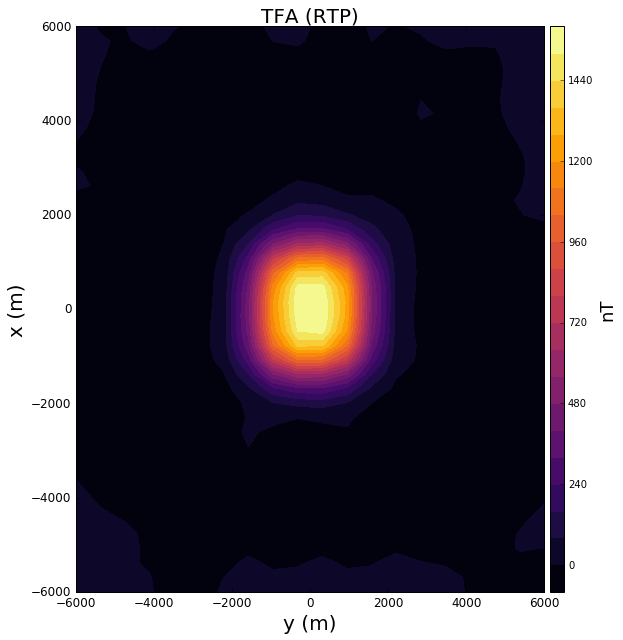

In [38]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_airborne_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

# Visualization of the RTP and Magnetic moment over the layer

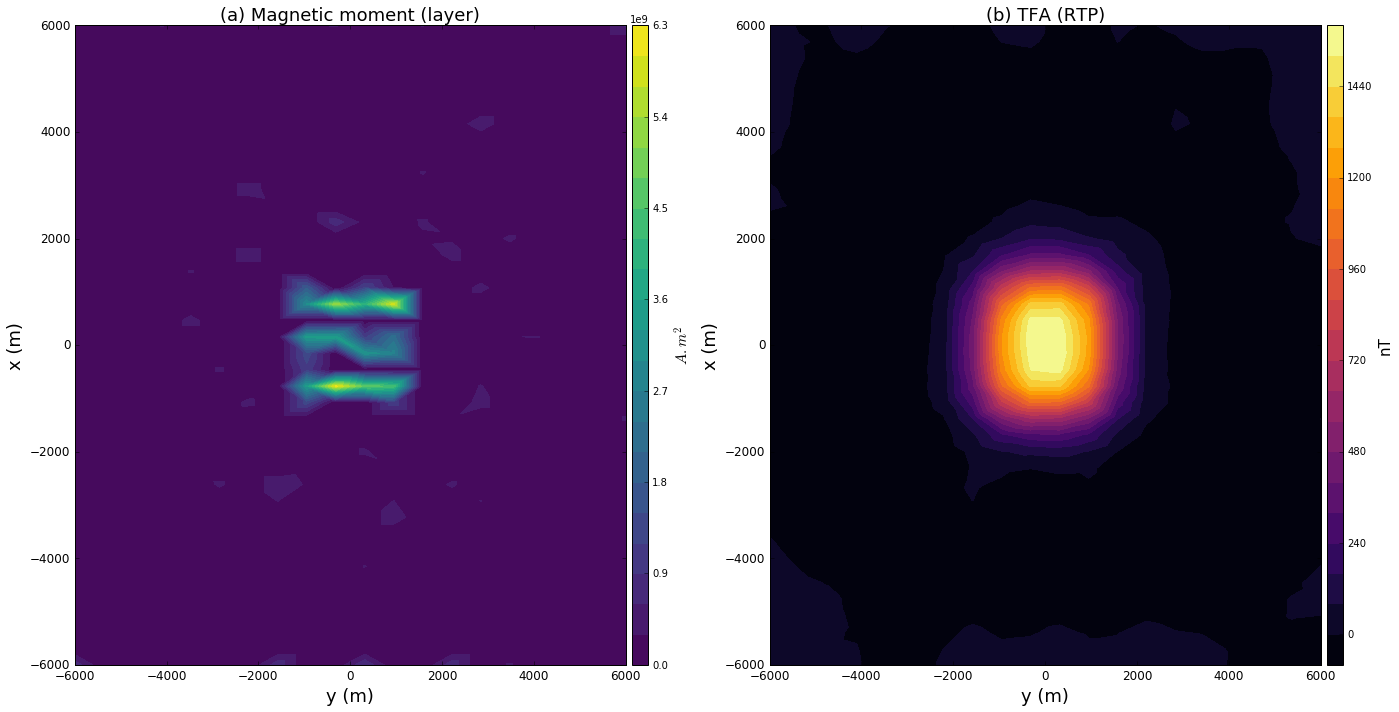

In [39]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(20,10), tight_layout=True)

plt.subplot(1,2,1)
plt.tricontourf(ys,xs,m_LM,20,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,2,2)
plt.tricontourf(airborne['y'],airborne['x'], tfa_rtp, 20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_moment_LM_NNLS_RM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

## Comparison between the RTP Calculated by equivalent layer and the true RTP field

In [40]:
r_rtp = tfa_rtp - data['tfa_obs_prism_PL_airb']

In [41]:
r_norm,r_mean,r_std = fc.residual(tfa_rtp,data['tfa_obs_prism_PL_airb'])

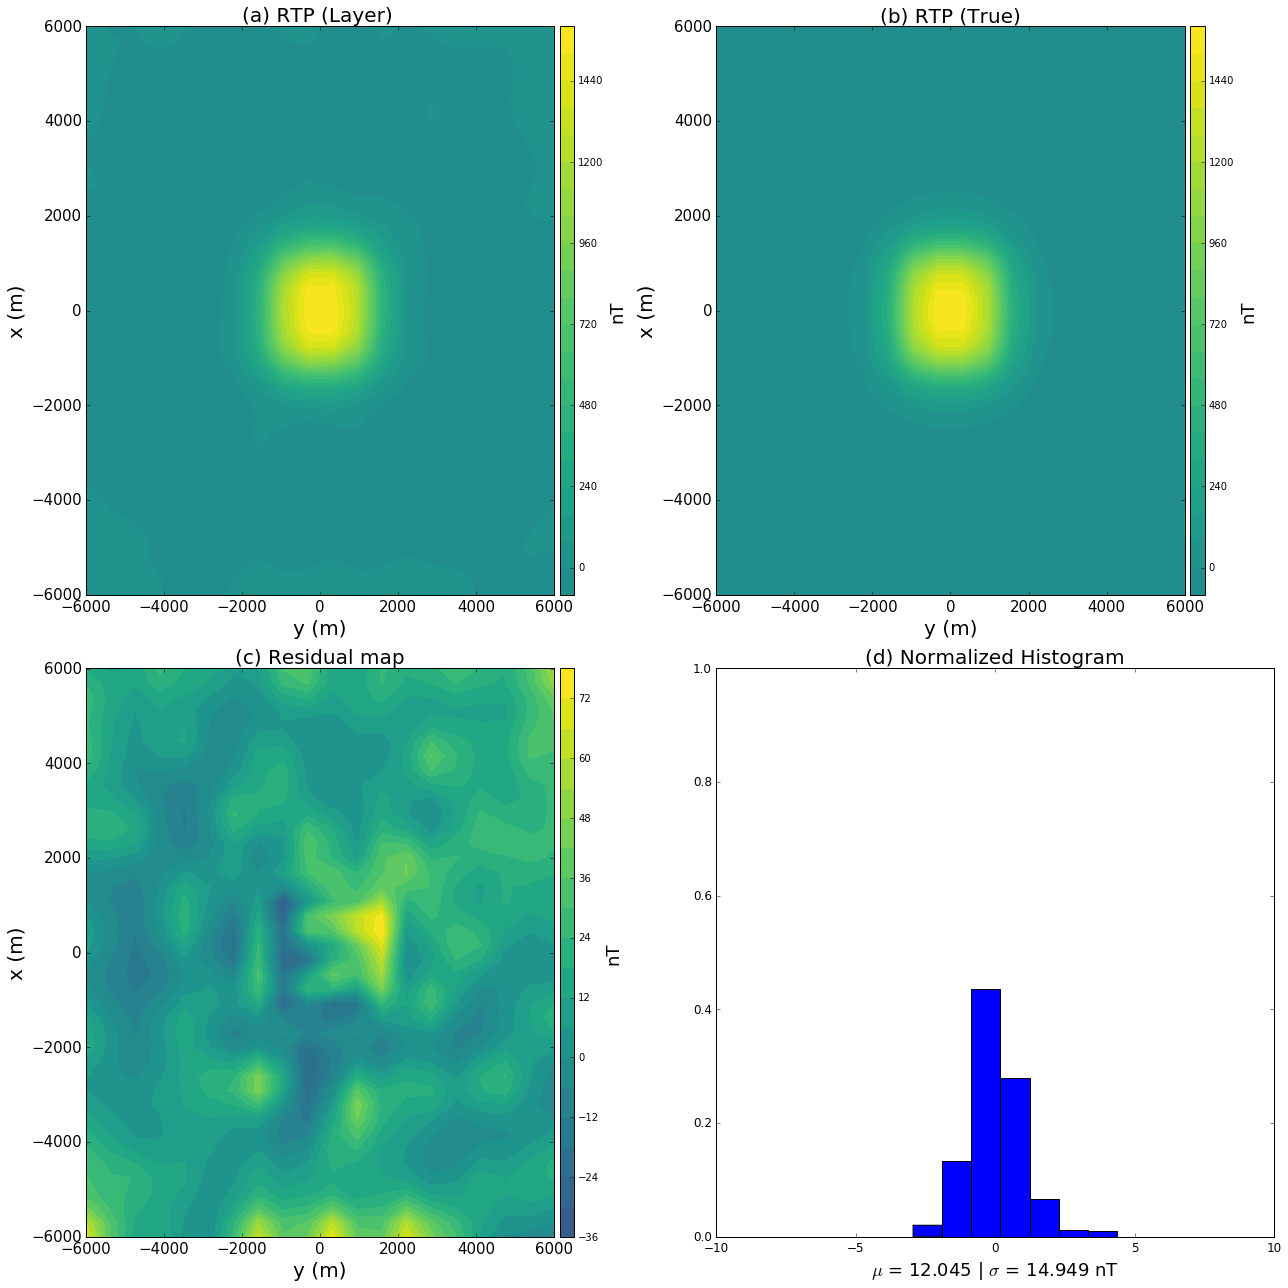

In [42]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(18,18), tight_layout=True)

ranges = saturation_factor*np.abs([tfa_rtp.max(), tfa_rtp.min(),
                                   data['tfa_obs_prism_PL_airb'].max(), data['tfa_obs_prism_PL_airb'].min()]).max()

r_ranges = saturation_factor*np.abs([r_rtp.max(), r_rtp.min()]).max()


plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             tfa_rtp.reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font) 
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) RTP (Layer) ', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             data['tfa_obs_prism_PL_airb'].reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) RTP (True)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_rtp.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/rtp_layer_true'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Results

In [43]:
result_RM_airb['magnetic_moment'] = m_LM
result_RM_airb['inc_est'] = inc_est
result_RM_airb['dec_est'] = dec_est
result_RM_airb['layer_depth'] = h
result_RM_airb['reg_patameter'] = mu_pos
result_RM_airb['RTP'] = tfa_rtp
result_RM_airb['tfa_predicted'] = pred

#### Generating .pickle file

In [44]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
result_RM_airb['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [45]:
file_name = 'data/result_RM_airb.pickle'
with open(file_name, 'w') as f:
    pickle.dump(result_RM_airb, f)
    
saved_files.append(file_name)


### Saved files

In [46]:
with open('reports/report_%s.md' % notebook_name[:st.index(notebook_name, '.')], 'w') as q:
    q.write('# Saved files \n')
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    q.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        q.write('*  `%s` \n' % (sf))

1  figs/airborne/convergence_LM_NNLS_magRM.png
2  figs/airborne/convergence_LM_NNLS_magRM.eps
3  figs/airborne/data_fitting_LM_NNLS_magRM.png
4  figs/airborne/data_fitting_LM_NNLS_magRM.eps
5  figs/airborne/magnetic_moment_positive_LM_NNLS_magRM.png
6  figs/airborne/magnetic_moment_positive_LM_NNLS_magRM.eps
7  figs/airborne/RTP_airborne_magRM.png
8  figs/airborne/RTP_airborne_magRM.eps
9  figs/airborne/RTP_moment_LM_NNLS_RM.png
10  figs/airborne/RTP_moment_LM_NNLS_RM.eps
11  figs/airborne/rtp_layer_true.png
12  figs/airborne/rtp_layer_true.eps
13  data/result_RM_airb.pickle
